### BetterTogether (TM)

In [1]:
import numpy as np
from astropy.table import Table, unique
from astropy import units as u
import astropy.coordinates as coord
from astropy.time import Time
from astropy.io import fits
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

In [5]:
cutoff = int(14e6)

In [7]:
gaia_table_file = '../data/gaia-kepler-dustin.fits'
hdul = fits.open(gaia_table_file)
gaia_src_tbl = Table(hdul[1].data[:cutoff])
gaia_src_tbl = gaia_src_tbl.to_pandas()

In [20]:
pairs_file = '../data/matched-pairs-dustin.fits'
hdul = fits.open(pairs_file)
pairs = hdul[0].data[:cutoff]
#pairs = pd.DataFrame(data=pairs)

In [9]:
hdul = fits.open('../data/chisqs_matched-pairs_first14m.fits')
chisqs = hdul[0].data[:cutoff]

Make a chi-squared cut & assemble the best pairs:

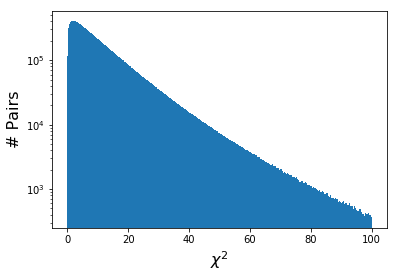

In [10]:
plt.hist(chisqs[(chisqs > 0.) & (chisqs < 100.)], bins=1000)
plt.xlabel('$\chi^2$', fontsize=16)
plt.ylabel('# Pairs', fontsize=16)
plt.yscale('log')
plt.savefig('chisq_keplerpairs.png')

In [11]:
matches_mask = (chisqs > 0) & (chisqs < 3)
np.sum(matches_mask)

11112529

In [14]:
matches_mask.shape

(14000000, 169)

In [17]:
pairs.shape

(14000000, 169)

In [94]:
len_inds, len_matches = np.shape(pairs)
pairs_inds = np.array([np.arange(len_inds),]*len_matches).transpose()
pairs_ind1s = pairs_inds[matches_mask]

In [95]:
pairs_ind2s = pairs[matches_mask]

Now let's select a random subset of 2048 pairs. We're actually going to select a larger subset and then grab only the ones where both members have significantly non-zero parallaxes.

In [96]:
np.random.seed(42)
rand_inds = np.random.randint(0, len(pairs_ind1s), 50000)
pairs_ind1s = pairs_ind1s[rand_inds]
pairs_ind2s = pairs_ind2s[rand_inds]

In [97]:
pairs_ind1s

array([ 6612489,  7271172, 13745712, ...,  3776889,  4780814,  8109697])

In [98]:
def make_x(star):
    """
    returns a vector of x = [parallax, pmra, pmdec]
    """
    names = ['parallax', 'pmra', 'pmdec']
    return star.loc[names].values.astype('f')

def make_xerr(star):
    """
    returns a vector of xerr = [parallax_error, pmra_error, pmdec_error]
    """
    err_names = ['parallax_error', 'pmra_error', 'pmdec_error']
    return star.loc[err_names].values.astype('f')   

def make_cov(star):
    """
    returns covariance matrix C corresponding to x
    """
    names = ['parallax', 'pmra', 'pmdec']
    C = np.diag(make_xerr(star))
    for i, name1 in enumerate(names):
        for j, name2 in enumerate(names):
            if j >= i:
                continue
            corr = star.loc["{0}_{1}_corr".format(name2, name1)]
            C[i, j] = corr * np.sqrt(C[i, i] * C[j, j])
            C[j, i] = C[i, j]
    return C

In [99]:
def chisq_nonzero(star):
    """
    Chisquared-like metric to diagnose how different from zero the parallax is
    """
    x = make_x(star)
    cov = make_cov(star)
    return np.dot(x, np.linalg.solve(cov, x))

In [100]:
nonzero_mask = np.zeros_like(pairs_ind1s, dtype=bool)
for i in tqdm(range(len(nonzero_mask))):
    star1 = gaia_src_tbl.iloc[pairs_ind1s[i]]
    try:
        star2 = gaia_src_tbl.iloc[pairs_ind2s[i]]
    except: # catches error when match index isn't part of the loaded table subset
        continue
    chisq_nonzero1 = chisq_nonzero(star1)
    chisq_nonzero2 = chisq_nonzero(star2)
    if (chisq_nonzero1 >= 5) and (chisq_nonzero2 >= 5):
        if (star1['parallax'] >= 0.) and (star2['parallax'] >= 0.):
            nonzero_mask[i] = True

100%|██████████| 50000/50000 [01:39<00:00, 504.08it/s]


In [101]:
np.sum(nonzero_mask)

23168

In [102]:
pairs_ind1s = pairs_ind1s[nonzero_mask][:2048]
pairs_ind2s = pairs_ind2s[nonzero_mask][:2048]

Calculate luminosities:

In [134]:
def read_match_attr(ind1, ind2, attr):
    return gaia_src_tbl.iloc[ind1][attr].values, gaia_src_tbl.iloc[ind2][attr].values

In [135]:
(gmag1, gmag2) = read_match_attr(pairs_ind1s, pairs_ind2s, 'phot_g_mean_mag')
(plx1, plx2) = read_match_attr(pairs_ind1s, pairs_ind2s, 'parallax')
dist1 = 1.e3/plx1
absg1 = gmag1 - 5.*(np.log10(dist1) - 1.)
dist2 = 1.e3/plx2
absg2 = gmag2 - 5.*(np.log10(dist2) - 1.)

In [136]:
absg1

array([ 4.276554 ,  8.403652 , 10.775026 , ...,  3.6653986,  9.269981 ,
        4.4777937], dtype=float32)

Now grab the fainter of each pair and make a CMD:

In [137]:
#pairs_2d = np.vstack([pairs_ind1s, pairs_ind2s])
#absgs_2d = np.vstack([absg1, absg2])
#argsort_absgs_2d = np.argsort(absgs_2d, axis=0)

In [138]:
# this is dumb but I can't figure out how to make the argsort method work:
pairs_indfaints = np.zeros_like(pairs_ind1s)
pairs_indbrights = np.zeros_like(pairs_ind1s)
for i in range(2048):
    if absg1[i] > absg2[i]:
        pairs_indfaints[i] = pairs_ind1s[i]
        pairs_indbrights[i] = pairs_ind2s[i]
    else:
        pairs_indfaints[i] = pairs_ind2s[i]
        pairs_indbrights[i] = pairs_ind1s[i]        

In [141]:
(gmag1, gmag2) = read_match_attr(pairs_indfaints, pairs_indbrights, 'phot_g_mean_mag')
(plx1, plx2) = read_match_attr(pairs_indfaints, pairs_indbrights, 'parallax')
dist1 = 1.e3/plx1
absg1 = gmag1 - 5.*(np.log10(dist1) - 1.)
dist2 = 1.e3/plx2
absg2 = gmag2 - 5.*(np.log10(dist2) - 1.)

In [142]:
absg1

array([ 7.1300097,  8.403652 , 10.775026 , ...,  8.219618 ,  9.269981 ,
        5.793105 ], dtype=float32)

In [143]:
(bp_rp1, bp_rp2) = read_match_attr(pairs_indfaints, pairs_indbrights, 'bp_rp')

(-0.8, 4.2)

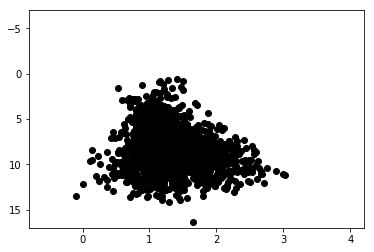

In [148]:
plt.scatter(bp_rp1, absg1, color='k')
plt.ylim([17,-7])
plt.xlim([-0.8, 4.2])

In [153]:
np.savetxt('../data/bettertogetherpairs.txt', np.vstack([pairs_indfaints, pairs_indbrights]).T, 
           header='pairs_indfaints, pairs_indbrights', delimiter=',', fmt='%.0i')